In [ ]:
%pip install numpy pandas seaborn scikit-learn xgboost

In [2]:
from google.colab import drive


In [34]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score,classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  StandardScaler, MinMaxScaler,MultiLabelBinarizer,LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer


In [5]:
train=pd.read_csv('/content/drive/MyDrive/FDS_FP/train.csv')
test=pd.read_csv('/content/drive/MyDrive/FDS_FP/test.csv')

In [6]:
display(train.dtypes)


,0
Location,object
Cross_Street,object
Latitude,float64
Longitude,float64
Date_Reported,object
Date_Occurred,object
Time_Occurred,float64
Area_ID,float64
Area_Name,object
Reporting_District_no,float64


Let's display the first rows of the training set to get an overview of its structure.

In [7]:
display(train.head())

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


Let's check whether there are any duplicates

In [8]:
print(train.duplicated().sum())

13


In fact, the training dataset contains duplicates; let's remove them.

In [9]:
train=train.drop_duplicates()
print(train.duplicated().sum())

0


We can notice there are some NaN values; let's investigate further.

In [10]:
display(train.isna().sum())

,0
Location,0
Cross_Street,16540
Latitude,0
Longitude,0
Date_Reported,0
Date_Occurred,0
Time_Occurred,0
Area_ID,0
Area_Name,0
Reporting_District_no,0


Since the number of Nan values in Cross_Street is very high, and there are a lot of other location information in the dataset, we dropt it.

In [11]:
train.drop(columns=['Cross_Street'],inplace=True)
display(train.isna().sum())

,0
Location,0
Latitude,0
Longitude,0
Date_Reported,0
Date_Occurred,0
Time_Occurred,0
Area_ID,0
Area_Name,0
Reporting_District_no,0
Part 1-2,0


Let's consider the Nan Value in Weapon_Used_Code as "no weapon used during the crime", and create a new category with maximum weapon_id +1 for that.




In [12]:
train['Weapon_Used_Code']=train['Weapon_Used_Code'].fillna(train['Weapon_Used_Code'].max()+ 1)
display(train.isna().sum())

,0
Location,0
Latitude,0
Longitude,0
Date_Reported,0
Date_Occurred,0
Time_Occurred,0
Area_ID,0
Area_Name,0
Reporting_District_no,0
Part 1-2,0


replace the Nan values in the following columns with the value that appears most frequently in each of them.

In [13]:
mode_victim_sex_value = train['Victim_Sex'].mode().iloc[0]  # Find the most frequent value
train['Victim_Sex']=train['Victim_Sex'].fillna(mode_victim_sex_value)
mode_victim_descent_value = train['Victim_Descent'].mode().iloc[0]  # Find the most frequent value
train['Victim_Descent']=train['Victim_Descent'].fillna(mode_victim_sex_value)
mode_modus_operandi_value = train['Modus_Operandi'].mode().iloc[0]  # Find the most frequent value
train['Modus_Operandi']=train['Modus_Operandi'].fillna(mode_modus_operandi_value)
train['Modus_Operandi']=train['Modus_Operandi'].apply(lambda x:str(x).split(" ") if x else [])
display(train.isna().sum())

,0
Location,0
Latitude,0
Longitude,0
Date_Reported,0
Date_Occurred,0
Time_Occurred,0
Area_ID,0
Area_Name,0
Reporting_District_no,0
Part 1-2,0


Let's convert date columns into datetime type

In [14]:
train['Date_Reported'] = pd.to_datetime(train['Date_Reported'],format='%m/%d/%Y %I:%M:%S %p')
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'],format='%m/%d/%Y %I:%M:%S %p')
train['Year_Reported'] = train['Date_Reported'].dt.year
train['Month_Reported'] = train['Date_Reported'].dt.month
train['Day_Reported'] = train['Date_Reported'].dt.day
train['Year_Occurred'] = train['Date_Occurred'].dt.year
train['Month_Occurred'] = train['Date_Occurred'].dt.month
train['Day_Occurred'] = train['Date_Occurred'].dt.day
train['Time_Occurred'] = train['Time_Occurred'].apply(lambda x: int(x // 100))
display(train.head())

,Location,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,...,Weapon_Description,Status,Status_Description,Crime_Category,Year_Reported,Month_Reported,Day_Reported,Year_Occurred,Month_Occurred,Day_Occurred
0,4500 CARPENTER AV,34.1522,-118.3910,2020-03-09,2020-03-06,18,15.0,N Hollywood,1563.0,1.0,...,NaN,IC,Invest Cont,Property Crimes,2020,3,9,2020,3,6
1,45TH ST,34.0028,-118.2391,2020-02-27,2020-02-27,13,13.0,Newton,1367.0,1.0,...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes,2020,2,27,2020,2,27
2,600 E MARTIN LUTHER KING JR BL,34.0111,-118.2653,2020-08-21,2020-08-21,6,13.0,Newton,1343.0,2.0,...,NaN,IC,Invest Cont,Property Crimes,2020,8,21,2020,8,21
3,14900 ORO GRANDE ST,34.2953,-118.4590,2020-11-08,2020-11-06,18,19.0,Mission,1924.0,1.0,...,NaN,IC,Invest Cont,Property Crimes,2020,11,8,2020,11,6
4,7100 S VERMONT AV,33.9787,-118.2918,2020-02-25,2020-02-25,11,12.0,77th Street,1245.0,1.0,...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes,2020,2,25,2020,2,25


In [15]:
display(train.loc[:, train.columns != 'Modus_Operandi'].nunique()) #Modus_Operandi is escluded due to its special data type, which is list, otherwise it will give error

,0
Location,12399
Latitude,3622
Longitude,3578
Date_Reported,811
Date_Occurred,366
Time_Occurred,24
Area_ID,21
Area_Name,21
Reporting_District_no,1120
Part 1-2,2


Let's display the distinct values of Target labels, Area_Name,Area_ID,Modus_Operandi, Victim_Age, Victim_Sex

In [16]:
display(train['Crime_Category'].unique())
display(train['Area_Name'].unique())
display(train['Area_ID'].unique())
display(train['Victim_Age'].unique())
display(train['Victim_Sex'].unique())
display(train['Weapon_Description'].unique())

array(['Property Crimes', 'Violent Crimes', 'Other Crimes',
       'Crimes against Public Order', 'Fraud and White-Collar Crimes',
       'Crimes against Persons'], dtype=object)

array(['N Hollywood', 'Newton', 'Mission', '77th Street', 'Northeast',
       'Hollenbeck', 'Pacific', 'Van Nuys', 'Devonshire', 'Wilshire',
       'Hollywood', 'Harbor', 'Topanga', 'Central', 'West Valley',
       'Olympic', 'Foothill', 'West LA', 'Southeast', 'Southwest',
       'Rampart'], dtype=object)

array([15., 13., 19., 12., 11.,  4., 14.,  9., 17.,  7.,  6.,  5., 21.,
        1., 10., 20., 16.,  8., 18.,  3.,  2.])

array([75., 41., 67., 61.,  0., 50., 68., 22., 31., 46., 72., 26., 38.,
       37., 42., 40., 53., 60., 29., 13., 33., 27., 15., 23., 74., 63.,
       78., 51., 44., 34., 69., 36., 52., 25., 49., 48., 32., 18., 35.,
       24., 39., 16., 28., 47., 30., 64., 76.,  5., 58., 45., 57., 19.,
       55., 54., 21., 65., 17., 20., 77., 82., 56., -2., 84., 59., 43.,
        7., 70., 66., 62., 14., 80., 71., 81., 96., 12., 11.,  4., 83.,
       10.,  8.,  6., 88., 86., 73.,  9., 87., 85., 93., 95., 99., 79.,
        3.,  2., 91., 92., 90., 89., 98., -1., 94.])

array(['M', 'X', 'F', 'H'], dtype=object)

array([nan, 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
       'VERBAL THREAT', 'OTHER KNIFE', 'HAND GUN',
       'UNKNOWN WEAPON/OTHER WEAPON', 'VEHICLE', 'FIRE',
       'PIPE/METAL PIPE', 'KNIFE WITH BLADE 6INCHES OR LESS',
       'BLUNT INSTRUMENT', 'CLUB/BAT', 'SEMI-AUTOMATIC PISTOL',
       'ROCK/THROWN OBJECT', 'MACHETE', 'UNKNOWN FIREARM',
       'AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'TOY GUN', 'FIXED OBJECT',
       'UNKNOWN TYPE CUTTING INSTRUMENT', 'FOLDING KNIFE', 'HAMMER',
       'PHYSICAL PRESENCE', 'MACE/PEPPER SPRAY',
       'OTHER CUTTING INSTRUMENT', 'BOARD', 'BOTTLE', 'KITCHEN KNIFE',
       'RIFLE', 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH', 'SCREWDRIVER',
       'STICK', 'SIMULATED GUN', 'BELT FLAILING INSTRUMENT/CHAIN',
       'CONCRETE BLOCK/BRICK', 'AXE', 'ICE PICK', 'REVOLVER',
       'OTHER FIREARM', 'SCISSORS', 'STARTER PISTOL/REVOLVER', 'GLASS',
       'SHOTGUN', 'BRASS KNUCKLES', 'SWITCH BLADE', 'TIRE IRON',
       'SAWED OFF RIFLE/SHOTGUN', 'CAUSTIC CH

Convert target label into number

In [17]:
label_encoder = LabelEncoder()
train['Crime_Category'] = label_encoder.fit_transform(train['Crime_Category'])

In [18]:
corr_df = train.corr(numeric_only=True)
corr_df

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code,Crime_Category,Year_Reported,Month_Reported,Day_Reported,Year_Occurred,Month_Occurred,Day_Occurred
Latitude,1.000000,-0.998911,0.006287,0.018403,0.017920,-0.036343,0.003244,-0.011285,-0.010880,0.021163,0.009954,-0.026001,-0.009866,NaN,-0.026332,-0.006040
Longitude,-0.998911,1.000000,-0.005651,-0.006481,-0.006139,0.036374,-0.002292,0.011209,0.012994,-0.021635,-0.009471,0.025036,0.009912,NaN,0.025441,0.006142
Time_Occurred,0.006287,-0.005651,1.000000,0.012553,0.012337,-0.030861,-0.018584,-0.057713,-0.016604,0.040239,-0.046304,-0.001190,0.016852,NaN,0.002007,0.034116
Area_ID,0.018403,-0.006481,0.012553,1.000000,0.999024,-0.002305,0.028676,0.004015,0.000885,-0.011236,0.016625,-0.004065,-0.008978,NaN,0.001122,-0.005207
Reporting_District_no,0.017920,-0.006139,0.012337,0.999024,1.000000,-0.001916,0.028423,0.004077,0.000846,-0.011727,0.016869,-0.004444,-0.008946,NaN,0.000693,-0.005365
Part 1-2,-0.036343,0.036374,-0.030861,-0.002305,-0.001916,1.000000,0.186775,0.254277,0.025002,-0.257903,0.105076,-0.007415,0.006681,NaN,-0.010164,-0.015107
Victim_Age,0.003244,-0.002292,-0.018584,0.028676,0.028423,0.186775,1.000000,0.191358,-0.086191,-0.030308,0.042607,-0.028974,-0.003746,NaN,-0.021693,-0.013624
Premise_Code,-0.011285,0.011209,-0.057713,0.004015,0.004077,0.254277,0.191358,1.000000,0.045689,-0.174466,0.126022,-0.018693,0.000502,NaN,-0.014114,-0.008276
Weapon_Used_Code,-0.010880,0.012994,-0.016604,0.000885,0.000846,0.025002,-0.086191,0.045689,1.000000,-0.163567,0.059595,-0.029791,-0.006270,NaN,-0.026203,-0.015888
Crime_Category,0.021163,-0.021635,0.040239,-0.011236,-0.011727,-0.257903,-0.030308,-0.174466,-0.163567,1.000000,-0.152219,0.003126,0.001142,NaN,0.001019,0.026699


we can observe that Year_Occurred produced Nan in the correaltion table, let find out the reason.

In [19]:
display(train['Year_Occurred'].nunique())

1

So all Year_Occurred has the same value, it means its standard deviation is zero. Correlation cannot be computed because the denominator involves dividing by the standard deviation. let's drop it

In [20]:
train.drop(columns=['Year_Occurred'],inplace=True)
corr_df = train.corr(numeric_only=True)
corr_df

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code,Crime_Category,Year_Reported,Month_Reported,Day_Reported,Month_Occurred,Day_Occurred
Latitude,1.000000,-0.998911,0.006287,0.018403,0.017920,-0.036343,0.003244,-0.011285,-0.010880,0.021163,0.009954,-0.026001,-0.009866,-0.026332,-0.006040
Longitude,-0.998911,1.000000,-0.005651,-0.006481,-0.006139,0.036374,-0.002292,0.011209,0.012994,-0.021635,-0.009471,0.025036,0.009912,0.025441,0.006142
Time_Occurred,0.006287,-0.005651,1.000000,0.012553,0.012337,-0.030861,-0.018584,-0.057713,-0.016604,0.040239,-0.046304,-0.001190,0.016852,0.002007,0.034116
Area_ID,0.018403,-0.006481,0.012553,1.000000,0.999024,-0.002305,0.028676,0.004015,0.000885,-0.011236,0.016625,-0.004065,-0.008978,0.001122,-0.005207
Reporting_District_no,0.017920,-0.006139,0.012337,0.999024,1.000000,-0.001916,0.028423,0.004077,0.000846,-0.011727,0.016869,-0.004444,-0.008946,0.000693,-0.005365
Part 1-2,-0.036343,0.036374,-0.030861,-0.002305,-0.001916,1.000000,0.186775,0.254277,0.025002,-0.257903,0.105076,-0.007415,0.006681,-0.010164,-0.015107
Victim_Age,0.003244,-0.002292,-0.018584,0.028676,0.028423,0.186775,1.000000,0.191358,-0.086191,-0.030308,0.042607,-0.028974,-0.003746,-0.021693,-0.013624
Premise_Code,-0.011285,0.011209,-0.057713,0.004015,0.004077,0.254277,0.191358,1.000000,0.045689,-0.174466,0.126022,-0.018693,0.000502,-0.014114,-0.008276
Weapon_Used_Code,-0.010880,0.012994,-0.016604,0.000885,0.000846,0.025002,-0.086191,0.045689,1.000000,-0.163567,0.059595,-0.029791,-0.006270,-0.026203,-0.015888
Crime_Category,0.021163,-0.021635,0.040239,-0.011236,-0.011727,-0.257903,-0.030308,-0.174466,-0.163567,1.000000,-0.152219,0.003126,0.001142,0.001019,0.026699


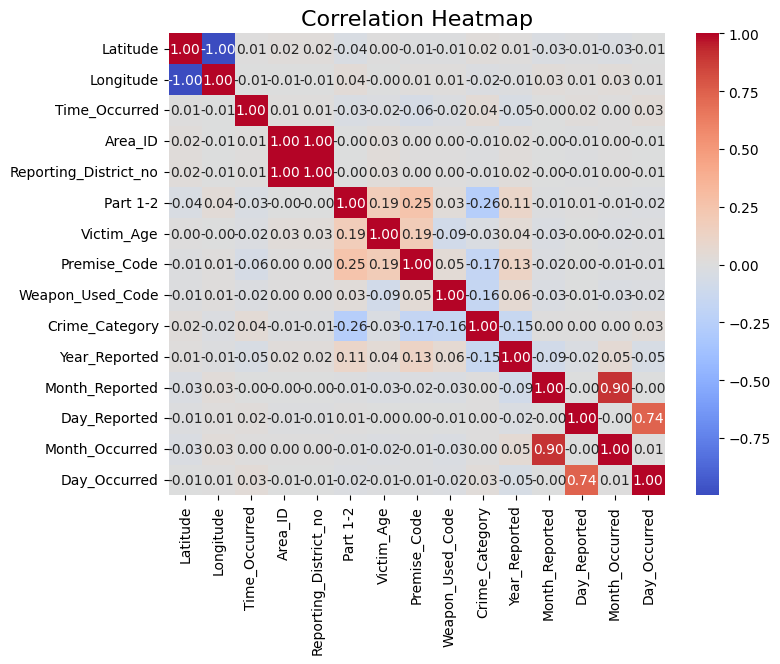

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

# Add a title
plt.title("Correlation Heatmap", fontsize=16)

# Display the plot
plt.show()

In [22]:
display(train.columns)

Index(['Location', 'Latitude', 'Longitude', 'Date_Reported', 'Date_Occurred',
       'Time_Occurred', 'Area_ID', 'Area_Name', 'Reporting_District_no',
       'Part 1-2', 'Modus_Operandi', 'Victim_Age', 'Victim_Sex',
       'Victim_Descent', 'Premise_Code', 'Premise_Description',
       'Weapon_Used_Code', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category', 'Year_Reported',
       'Month_Reported', 'Day_Reported', 'Month_Occurred', 'Day_Occurred'],
      dtype='object')

In [23]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19987 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Location               19987 non-null  object        
 1   Latitude               19987 non-null  float64       
 2   Longitude              19987 non-null  float64       
 3   Date_Reported          19987 non-null  datetime64[ns]
 4   Date_Occurred          19987 non-null  datetime64[ns]
 5   Time_Occurred          19987 non-null  int64         
 6   Area_ID                19987 non-null  float64       
 7   Area_Name              19987 non-null  object        
 8   Reporting_District_no  19987 non-null  float64       
 9   Part 1-2               19987 non-null  float64       
 10  Modus_Operandi         19987 non-null  object        
 11  Victim_Age             19987 non-null  float64       
 12  Victim_Sex             19987 non-null  object        
 13  Victim

None

Let's convert floats to ints

In [24]:
columns_to_convert = ['Latitude', 'Longitude', 'Area_ID','Reporting_District_no', 'Part 1-2', 'Victim_Age','Premise_Code','Weapon_Used_Code']
train[columns_to_convert] = train[columns_to_convert].astype(int)

In [25]:
included_columns=['Location', 'Latitude', 'Longitude','Area_ID','Reporting_District_no','Part 1-2','Modus_Operandi', 'Victim_Age','Victim_Sex', 'Victim_Descent', 'Premise_Code','Weapon_Used_Code','Status','Crime_Category', 'Year_Reported',
       'Month_Reported', 'Day_Reported', 'Month_Occurred', 'Day_Occurred']

In [26]:
new_train=train[included_columns]
display(new_train.isna().sum())
display(new_train.dtypes)
new_train

,0
Location,0
Latitude,0
Longitude,0
Area_ID,0
Reporting_District_no,0
Part 1-2,0
Modus_Operandi,0
Victim_Age,0
Victim_Sex,0
Victim_Descent,0


,0
Location,object
Latitude,int64
Longitude,int64
Area_ID,int64
Reporting_District_no,int64
Part 1-2,int64
Modus_Operandi,object
Victim_Age,int64
Victim_Sex,object
Victim_Descent,object


,Location,Latitude,Longitude,Area_ID,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Crime_Category,Year_Reported,Month_Reported,Day_Reported,Month_Occurred,Day_Occurred
0,4500 CARPENTER AV,34,-118,15,1563,1,[0385],75,M,W,101,516,IC,4,2020,3,9,3,6
1,45TH ST,34,-118,13,1367,1,"[0906, 0352, 0371, 0446, 1822, 0344, 0416, 0417]",41,M,H,216,400,IC,4,2020,2,27,2,27
2,600 E MARTIN LUTHER KING JR BL,34,-118,13,1343,2,"[0329, 1202]",67,M,B,501,516,IC,4,2020,8,21,8,21
3,14900 ORO GRANDE ST,34,-118,19,1924,1,"[0329, 1300]",61,M,H,101,516,IC,4,2020,11,8,11,6
4,7100 S VERMONT AV,33,-118,12,1245,1,"[0416, 0945, 1822, 0400, 0417, 0344]",0,X,X,401,400,IC,4,2020,2,25,2,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5100 W ADAMS BL,34,-118,3,303,2,"[0416, 0446, 2004, 0913]",51,M,H,501,400,IC,5,2020,5,24,5,24
19996,16900 ROSCOE BL,34,-118,10,1008,1,"[1822, 0209, 0344, 1414, 1420]",0,M,W,301,516,IC,4,2020,12,25,12,25
19997,1000 S SHENANDOAH ST,34,-118,8,849,1,"[0344, 1822, 1420]",42,M,H,102,516,IC,4,2020,9,25,9,25
19998,300 W SEPULVEDA ST,33,-118,5,558,2,"[1202, 2038, 0913, 0602, 1242, 0553]",76,F,H,501,516,IC,1,2020,6,10,6,10


Seperate training data into X and y

In [27]:
X = new_train.drop('Crime_Category', axis=1)
y = new_train['Crime_Category']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train

,Location,Latitude,Longitude,Area_ID,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Year_Reported,Month_Reported,Day_Reported,Month_Occurred,Day_Occurred
16812,800 S FIGUEROA ST,34,-118,1,162,2,"[0416, 1822, 2004]",34,M,K,102,400,IC,2020,2,10,2,10
12668,1100 S HILL ST,34,-118,1,185,2,[0928],38,F,K,710,516,IC,2022,5,25,9,19
841,GRAPE ST,33,-118,18,1849,1,"[1822, 0329, 1300, 0344, 1302, 1307, 1609]",33,M,H,101,500,IC,2020,10,31,10,31
6070,500 WORLD WAY,33,-118,14,1494,1,[0344],31,M,H,212,516,IC,2020,7,22,7,22
7763,2100 SUNSET PLAZA DR,34,-118,6,631,2,"[0913, 2038]",68,M,W,501,516,IC,2020,2,25,2,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11289,8500 TOBIAS AV,34,-118,19,1985,2,"[0416, 1813, 2000, 0913]",38,M,H,502,400,AO,2020,11,26,11,26
11969,MENLO AV,33,-118,12,1248,1,"[2000, 1814, 0444, 0429, 0334, 0913]",36,F,H,101,200,IC,2020,12,22,12,22
5391,1100 PALMS BL,33,-118,14,1433,2,"[0500, 0913, 0531, 1820, 0503]",21,F,A,501,400,AO,2020,1,22,1,19
860,2100 W 84TH ST,33,-118,12,1263,2,"[2000, 0913, 1813, 1821, 0416, 0444]",34,F,B,501,400,IC,2020,8,2,8,2


In [30]:
# Custom Transformer for MultiLabelBinarizer for the feature Modus Operandi, which is multilabeled
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ml_binarizers = {}

    def fit(self, X, y=None):
        """
        Fit a MultiLabelBinarizer for each column in the input DataFrame.
        """
        for column in X.columns:
            mlb = MultiLabelBinarizer()
            mlb.fit(X[column])
            self.ml_binarizers[column] = mlb
        return self

    def transform(self, X):
        """
        Transform the input DataFrame by applying the corresponding MultiLabelBinarizer
        for each column and concatenating the binary matrices.
        """
        X_transformed = []
        for column in X.columns:
            mlb = self.ml_binarizers[column]
            transformed_data = mlb.transform(X[column])
            # Create a DataFrame with meaningful column names
            transformed_df = pd.DataFrame(
                transformed_data,
                columns=[f"{column}_{cls}" for cls in mlb.classes_]
            )
            X_transformed.append(transformed_df)
        # Concatenate all transformed columns
        return pd.concat(X_transformed, axis=1)

In [35]:
# Define ColumnTransformer with merged transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'),['Area_ID','Reporting_District_no','Part 1-2','Victim_Sex','Victim_Descent','Premise_Code','Weapon_Used_Code','Status','Victim_Sex','Location']),
        ('minmax_scaler', MinMaxScaler(),['Latitude', 'Longitude','Victim_Age'])
        , ('modus_operandi', MultiLabelBinarizerTransformer(),['Modus_Operandi'])
        ],
        remainder='passthrough'  # Pass through any remaining columns that are not specified in transformers
        )

In [36]:
pipeline = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    XGBClassifier()
)


In [39]:
grid = dict(
    {
    'xgbclassifier__n_estimators': [42,44,46,48],
    'xgbclassifier__max_depth': [8,9,10]
}
)

In [40]:
pipe_cv = GridSearchCV(pipeline,grid,cv=6,verbose=1,n_jobs=-1)
if pipe_cv is not None:
    pipe_cv.fit(X_train, y_train)

    print(f"Best score: {pipe_cv.best_score_}")
    for hp, val in pipe_cv.best_params_.items():
        print(f"{hp}: {val}")

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best score: 0.9566575722063528
xgbclassifier__max_depth: 9
xgbclassifier__n_estimators: 46


In [41]:
#pipeline.fit(X_train,y_train)
y_pred_xgb = pipe_cv.predict(X_test)
print("XGBClassifier Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBClassifier Model:
Accuracy: 0.951975987993997
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.60      0.68        53
           1       0.82      0.87      0.85       364
           2       0.94      0.93      0.93       274
           3       0.44      0.21      0.28        34
           4       0.99      0.98      0.99      2310
           5       0.93      0.96      0.94       963

    accuracy                           0.95      3998
   macro avg       0.82      0.76      0.78      3998
weighted avg       0.95      0.95      0.95      3998



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['0347', '0350', '0402', '0410', '0437', '0543', '0547', '0550', '0933', '0946', '1012', '1021', '1239', '1248', '1277', '1316', '1411', '1538', '2011', '2019'] will be ignored
  warnings.warn(
